# Logistic Regression and SGD Homework 
***
**Name**: Saikrishna Jaliparthy 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [55]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [56]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [57]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

In [58]:
print("The length of vocabulary is: ",len(vocab))
print("\n")
print("In the code it creating features like when ever the word is identified it increases by count. So we can conclude that the text model being used is a Bag of words Model")
print("\n")
print("The Label for motorcycles is: 1 & The Label for Automobiles is: 0")


The length of vocabulary is:  5327


In the code it creating features like when ever the word is identified it increases by count. So we can conclude that the text model being used is a Bag of words Model


The Label for motorcycles is: 1 & The Label for Automobiles is: 0


### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [59]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
    
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
                
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        # TODO implement LSR updates of weights 
        self.w = self.w
        
        x=train_example.x
        y=train_example.y
        
        nz=train_example.nonzero
        sig=self.sigmoid(self.w.dot(x))
        for i in nz:
            if iteration==0: 
                self.last_update[i]=0
            if i not in self.last_update:
                self.last_update[i]=0
            self.w[i]=self.w[i]-(self.eta*(sig-y)*x[i])
            self.w[i]=self.w[i]*np.power((1-2*self.eta*self.lam),(iteration-self.last_update[i]+1))
            self.last_update[i]=iteration+1
        self.w[0]=self.w[0]-(self.eta*(sig-y))
        return self.w
    
    def bestmowords(self):
        z=[]
        zc=np.array(self.w)
        for i in range(0,10):
            maxx=np.amax(zc)
            idx=np.where(zc==maxx)[0]
            #print(idx)
            z.append(idx[0])
            zc[idx]=0
            i=i+1
        return z
        
    def bestauwords(self):
        z1=[]
        zc1=np.array(self.w)
        for i1 in range(0,10):
            minn=np.amin(zc1)
            idx1=np.where(zc1==minn)[0]
            #print(idx)
            z1.append(idx1[0])
            zc1[idx1]=0
            i1=i1+1
        return z1
    
    def badwords(self):
        z2=[]
        qwe=np.argsort((self.w))
        m1=(int) (len(qwe)-1)/2
        middle=int(m1)
        for i2 in range(middle-5,middle):
            z2.append(i2)
        for i3 in range(middle,middle+5):
            z2.append(i3)
        
        return z2

In [60]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(isVerbose=True)

Update     0  TrnNLL  799.294  TstNLL   81.287  TrnA 0.498  TstA 0.534
Update     5  TrnNLL  679.659  TstNLL   67.393  TrnA 0.635  TstA 0.664
Update    10  TrnNLL  3699.404  TstNLL  364.627  TrnA 0.510  TstA 0.552
Update    15  TrnNLL  3376.659  TstNLL  330.103  TrnA 0.523  TstA 0.560
Update    20  TrnNLL  2480.028  TstNLL  244.475  TrnA 0.553  TstA 0.586
Update    25  TrnNLL  2445.886  TstNLL  242.589  TrnA 0.559  TstA 0.586
Update    30  TrnNLL  1404.998  TstNLL  147.011  TrnA 0.663  TstA 0.647
Update    35  TrnNLL  957.733  TstNLL  106.194  TrnA 0.734  TstA 0.724
Update    40  TrnNLL  521.316  TstNLL   69.788  TrnA 0.819  TstA 0.784
Update    45  TrnNLL  467.808  TstNLL   57.568  TrnA 0.839  TstA 0.819
Update    50  TrnNLL  459.871  TstNLL   57.341  TrnA 0.842  TstA 0.819
Update    55  TrnNLL  442.292  TstNLL   57.689  TrnA 0.847  TstA 0.793
Update    60  TrnNLL  431.716  TstNLL   54.376  TrnA 0.853  TstA 0.819
Update    65  TrnNLL  431.508  TstNLL   54.356  TrnA 0.853  TstA 0.819
U

Update   590  TrnNLL  129.563  TstNLL   23.089  TrnA 0.955  TstA 0.897
Update   595  TrnNLL  132.610  TstNLL   22.659  TrnA 0.954  TstA 0.914
Update   600  TrnNLL  132.680  TstNLL   22.569  TrnA 0.954  TstA 0.922
Update   605  TrnNLL  132.057  TstNLL   22.638  TrnA 0.954  TstA 0.897
Update   610  TrnNLL  131.154  TstNLL   22.344  TrnA 0.957  TstA 0.914
Update   615  TrnNLL  131.141  TstNLL   22.342  TrnA 0.958  TstA 0.914
Update   620  TrnNLL  131.133  TstNLL   21.907  TrnA 0.958  TstA 0.914
Update   625  TrnNLL  137.285  TstNLL   21.713  TrnA 0.958  TstA 0.914
Update   630  TrnNLL  133.080  TstNLL   21.577  TrnA 0.959  TstA 0.914
Update   635  TrnNLL  133.013  TstNLL   21.576  TrnA 0.959  TstA 0.914
Update   640  TrnNLL  132.809  TstNLL   21.564  TrnA 0.959  TstA 0.914
Update   645  TrnNLL  130.864  TstNLL   21.676  TrnA 0.960  TstA 0.914
Update   650  TrnNLL  129.429  TstNLL   21.864  TrnA 0.959  TstA 0.914
Update   655  TrnNLL  128.870  TstNLL   21.817  TrnA 0.959  TstA 0.914
Update

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [61]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [62]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

Text(0,0.5,'Accuracy')

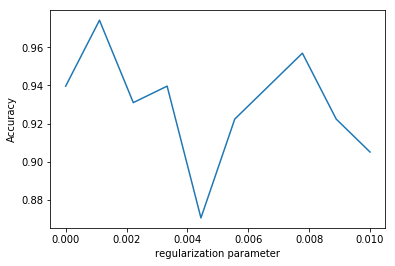

In [42]:
o=[]
v=np.linspace(0,.01,10)
for i in v:
    lr = LogReg(train_set, test_set, lam=i, eta=0.1)
    lr.train()
    o.append(lr.test_acc[-1])
    #print("The regularization parameter is: ",i, "Accuracy is: ",lr.test_acc[-1])
plt.plot(v,o)
plt.xlabel('regularization parameter')
plt.ylabel('Accuracy')

From the above illustration of the graph between regularization parameter and the accuracy of the classifier. We can say that for different values of regularization parameter we will arrive at different accuracy for the classifier. So from above graph we can conclude the maximum accuracy of the classifier is achieved at regularization parameter 0.001. 

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

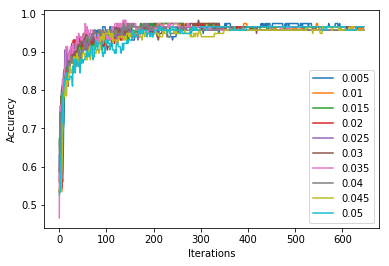

The eta values are:  [0.0050000000000000001, 0.01, 0.014999999999999999, 0.02, 0.025000000000000001, 0.030000000000000002, 0.034999999999999996, 0.040000000000000001, 0.044999999999999998, 0.049999999999999996]


The area is: [12270.3591954023, 12248.577586206899, 12268.994252873563, 12207.672413793105, 12224.410919540231, 12294.554597701152, 12290.675287356322, 12214.181034482759, 12100.459770114943, 12146.652298850577]


The  Accuracy is: [0.9568965517241379, 0.9568965517241379, 0.9568965517241379, 0.9568965517241379, 0.9568965517241379, 0.9655172413793104, 0.9568965517241379, 0.9568965517241379, 0.9568965517241379, 0.9655172413793104]


In [47]:
from scipy.integrate import simps
report_step=5
num_epochs=3
area=[]
acu=[]
etaa=[]
for i in np.arange(0.005, 0.055, 0.005):
    lra=[]
    it=[]
    
    lg = LogReg(train_set, test_set, lam=0.001, eta=i)
    lg.train(num_epochs=3, isVerbose=False, report_step=5)
    lra.append(lg.test_acc)
    for j in range(len(lg.test_acc)):
        it.append(j)
    plt.plot(it,np.array(lra).reshape(-1),label=str(i))
    area.append(simps(lg.test_acc,dx=20))
    acu.append(lg.test_acc[-1])
    etaa.append(i)

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
print("The eta values are: ",etaa)
print("\n")
print("The area is:",area)
print("\n")
print("The  Accuracy is:",acu)

By observing the above generated graph and dervied values we can conclude that fastest convergenece when it reaches maximum area on the validation set at corresponding learning rate is:  0.03

By observing the above generated graph and derived values we can conclude that fastest convergence occurs at highest accuracy on the validation set at the corresponding learning rate is:  0.03

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [64]:
lr = LogReg(train_set, test_set, lam=0.01, eta=0.1)
lr.train()
om=[]
print("Best words for Motorcycle: ")
mo=lr.bestmowords()
for i in mo:
    om.append(vocab[i])
print(om)

oa=[]
print("Best words for Automobile: ")
au=lr.bestauwords()
for i in au:
    oa.append(vocab[i])
print(oa)

Best words for Motorcycle: 
['bike', 'dod', 'bikes', 'pressure', 'exhaust', 'riding', 'battery', 'intake', 'rider', 'ride']
Best words for Automobile: 
['car', 'cars', 'spring', 'pack', 'ford', 'power', 'salesman', 'michael', 'right', 'BIAS_CONSTANT']


For finding the best predictors in the class of Motorcycle we have to consider the first 10 maximum values of weights in the weight values updated by training. when we take a look at equation where we are updating  weights the label (y) here is 1 so the updated weights we are obtaining are the maximum when we compared with the weights we are getting from label 0.

For finding the best predictors in the class of Automobile we have to consider the first 10 minimum values of weights in the weight values updated by training.when we take a look at equation where we are updating  weights the label (y) here is 0 so the updated weights we are obtaining are the minimum when we compared with the weights we are getting from label 1.

**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [65]:
lr = LogReg(train_set, test_set, lam=0.01, eta=0.1)
lr.train()
ow=[]
print("Worst words: ")
bad = lr.badwords()
for i in bad:
    ow.append(vocab[i])
print(ow)

Worst words: 
['unhappy', 'individual', 'virago', 'brent', 'decision', 'pen', 'flow', 'cafe', 'valves', 'shock']


For finding the 10 words of worst predictors for the class we have to consider the weights value obtained by the training and find the 10 values around the middle value of corresponding weights and these values will be present in both motorcycles and automobiles class